In [2]:
import torch
from core.model import GPT, GPTConfig
from core.tokenizer import Tokenizer, AudioTokenizer
from huggingface_hub import hf_hub_download
import numpy as np
import soundfile as sf
from IPython.display import Audio


In [3]:
model_config = GPTConfig.from_pretrained('EleutherAI/pythia-70m')
model = GPT(model_config)
tokenizer = Tokenizer()
audio_tokenizer = AudioTokenizer()

number of parameters: 21.02M
Loading Audio Encoder


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Loaded Audio Encoder, size: 1029


In [4]:
# Step 1, load the model

model_name = 'alexedw/audio-audio-only-tiny-model-7'
model_checkpoint = '40000'

state_dict = torch.load(hf_hub_download(model_name, "model_state.pt", revision=model_checkpoint), map_location='cpu')
new_state_dict = {key.replace("_orig_mod.", ""): value for key, value in state_dict.items()}

model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [11]:
input_text = 'since many items may pertain to do not show the caseload.'.lower()
tokenized_text = tokenizer.encode(input_text)

# full_text_tokens = np.array([tokenizer.start_text_id])
# full_audio_tokens = np.array([audio_tokenizer.start_text_id])
full_text_tokens = np.concatenate([np.array([tokenizer.start_text_id]), tokenized_text, np.array([tokenizer.end_text_id])])
full_audio_tokens = np.concatenate([np.array([audio_tokenizer.start_text_id]), np.array([audio_tokenizer.text_id] * len(tokenized_text)), np.array([audio_tokenizer.end_text_id])])


full_text_tokens = torch.tensor(full_text_tokens).unsqueeze(0).to('cpu')
full_audio_tokens_1 = torch.tensor(full_audio_tokens).unsqueeze(0).to('cpu')
full_audio_tokens_2 = torch.tensor(full_audio_tokens).unsqueeze(0).to('cpu')

output_text, output_audio_1, output_audio_2 = model.generate(full_text_tokens, full_audio_tokens_1, full_audio_tokens_2, 80, temperature=0.85, top_p=0.85)
# output_text, output_audio_1, output_audio_2 = model.generate(full_text_tokens, full_audio_tokens_1, full_audio_tokens_2, 150, temperature=0.85, top_p=0.85)
output_text, output_audio_1, output_audio_2 = output_text.cpu(), output_audio_1.cpu(), output_audio_2.cpu()

start_audio = len(full_audio_tokens) + 1
end_audio = len(output_audio_1[0])

audio_tokens_1 = output_audio_1[0, start_audio:end_audio]
audio_tokens_2 = output_audio_2[0, start_audio:end_audio]

audio_tokens_stacked = torch.stack([audio_tokens_1, audio_tokens_2], dim=0)
audio_tokens_stacked = torch.clamp(audio_tokens_stacked, min=0, max=1023)

sound = audio_tokenizer.decode(audio_tokens_stacked)

wav_filename = "temp_audio2.ignore.wav"
sf.write(wav_filename, sound.detach().numpy(), 24000)
display(Audio(filename=wav_filename))

100%|██████████| 80/80 [00:01<00:00, 65.08it/s]


In [147]:
fake_output_text = torch.tensor([[50277, 17480, 1142, 4957, 778, 6925, 404, 281, 247, 2014, 1083, 13, 841, 8442, 513, 417, 921, 253, 6483, 293, 1376, 15, 50278, 50279, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,50281, 50281] ])

fake_output_audio_1 = torch.tensor([[1025, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1026, 1027, 738, 53, 47, 47, 47, 160, 148, 148, 840, 960, 822, 24, 945, 530, 344, 347, 339, 47, 744, 47, 934, 463, 339, 835, 709, 339, 746, 977, 16, 141, 657, 838, 1021, 495, 860, 1010, 752, 319, 838, 940, 151, 151, 881, 881, 666, 666, 275, 370, 233, 788, 233, 588, 59, 385, 645, 890, 833, 931, 871, 404, 887, 145, 433, 753, 862, 690, 1001, 860, 1001, 860, 1001, 860, 321, 496, 934, 574, 160, 160, 463, 834, 131, 321, 860, 890, 833, 206, 154, 154, 540, 540, 540, 906, 598, 106, 779, 430, 834, 461, 475, 472, 323, 858, 944, 23, 1019, 106, 475, 106, 145, 619, 148, 463, 339, 25, 255, 388, 727, 502, 151, 151, 151, 1001, 151, 151, 598, 1001, 530, 860, 598, 699, 1019, 1019, 430, 66, 145, 339, 779, 472, 858, 424, 30, 807, 155, 690, 495, 879, 724, 574, 574,]])

fake_output_audio_2 = torch.tensor([[1025, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1029, 1026, 1027, 993, 1010, 36, 196, 973, 747, 408, 772, 13, 792, 0, 948, 857, 172, 569, 647, 826, 596, 4, 857, 892, 894, 857, 747, 160, 857, 259, 425, 274, 822, 869, 869, 869, 347, 604, 673, 711, 662, 662, 2, 642, 856, 186, 872, 167, 583, 577, 228, 593, 64, 549, 981, 593, 444, 26, 598, 727, 703, 417, 228, 984, 502, 4, 700, 214, 745, 809, 931, 674, 708, 444, 414, 664, 991, 541, 758, 758, 758, 646, 758, 176, 758, 252, 533, 651, 512, 824, 662, 662, 662, 998, 991, 460, 519, 888, 519, 519, 94, 898, 1002, 568, 346, 182, 252, 872, 580, 1007, 424, 860, 420, 1010, 870, 222, 754, 750, 674, 167, 198, 192, 298, 568, 824, 566, 708, 193, 193, 198, 931, 214, 743, 741, 516, 516, 892, 420, 268, 466, 942, 619, 375, 192, 931, 667, 54, 1014, 580, 1023, 974, 420]])

random_audio_output = torch.randint(0, 1023, (1, 173))
static_audio_output = torch.ones((1, 173), dtype=torch.int64) * 2

start_audio = 23#len(full_audio_tokens) + 1
end_audio = len(output_text[0])

audio_tokens_1 = fake_output_audio_1[0, start_audio:end_audio]
audio_tokens_2 = static_audio_output[0, start_audio:end_audio]

audio_tokens_stacked = torch.stack([audio_tokens_1, audio_tokens_2], dim=0)
audio_tokens_stacked = torch.clamp(audio_tokens_stacked, min=0, max=1023)

sound = audio_tokenizer.decode(audio_tokens_stacked)

wav_filename = "temp_audio2.ignore.wav"
sf.write(wav_filename, sound.detach().numpy(), 24000)
display(Audio(filename=wav_filename))

In [148]:
torch.arange(5)[:-1]
output_text.shape

torch.Size([1, 173])

In [149]:
output_text

tensor([[50277, 17480,  1142,  4957,   778,  6925,   404,   281,   247,  2014,
          1083,    13,   841,  8442,   513,   417,   921,   253,  6483,   293,
          1376,    15, 50278, 50279, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281, 50281,
         50281, 50281, 50281, 50281, 50281, 50281, 5

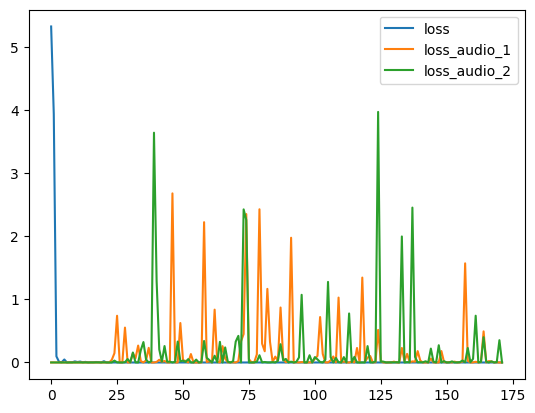

In [163]:
import torch.nn.functional as F
import pandas as pd
# lets check loss values
output_text, output_audio_1, output_audio_2
in1,in2,in3 = output_text[:, :-1], fake_output_audio_1[:, :-1], fake_output_audio_2[:, :-1]
target1,target2,target3 = output_text[:, 1:], fake_output_audio_1[:, 1:], fake_output_audio_2[:, 1:]

logits, logits_audio_1, logits_audio_2, loss = model(in1, target1, in2, in3, target2, target3)

loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target1.view(-1), ignore_index=-1, reduction='none')
loss_audio_1 = F.cross_entropy(logits_audio_1.view(-1, logits_audio_1.size(-1)), target2.view(-1), ignore_index=-1, reduction='none')
loss_audio_2 = F.cross_entropy(logits_audio_2.view(-1, logits_audio_2.size(-1)), target3.view(-1), ignore_index=-1, reduction='none')

# show losses as graph
import matplotlib.pyplot as plt
plt.plot(loss.detach().cpu().numpy(), label='loss')
plt.plot(loss_audio_1.detach().cpu().numpy(), label='loss_audio_1')
plt.plot(loss_audio_2.detach().cpu().numpy(), label='loss_audio_2')
plt.legend()


In [144]:
loss + loss_audio_1 + loss_audio_2

tensor(33.5681, grad_fn=<AddBackward0>)

In [86]:
import torch.nn.functional as F

In [20]:
tokenizer.decode(output_text)

'<|start_text|>since many items may pertain to a single case, these figures do not show the caseload.<|end_text|><|start_audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|><|audio|

In [128]:
from datasets import load_dataset, Audio as AudioHF
librispeech_dummy = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
librispeech_dummy = librispeech_dummy.cast_column("audio", AudioHF(sampling_rate=24000))
audio_sample = librispeech_dummy[0]["audio"]["array"]

audio_tokens_raw = audio_tokenizer.encode(audio_sample)

full_text_tokens = np.concatenate([np.array([tokenizer.start_audio_id]), np.array([tokenizer.audio_id] * len(audio_tokens_raw[0])), np.array([tokenizer.end_audio_id])])
full_audio_tokens_1 = np.concatenate([np.array([audio_tokenizer.start_audio_id]), audio_tokens_raw[0].numpy(), np.array([audio_tokenizer.end_audio_id])])
full_audio_tokens_2 = np.concatenate([np.array([audio_tokenizer.start_audio_id]), audio_tokens_raw[1].numpy(), np.array([audio_tokenizer.end_audio_id])])

full_text_tokens = torch.tensor(full_text_tokens).unsqueeze(0).cuda()
full_audio_tokens_1 = torch.tensor(full_audio_tokens_1).unsqueeze(0).cuda()
full_audio_tokens_2 = torch.tensor(full_audio_tokens_2).unsqueeze(0).cuda()

output_text, output_audio_1, output_audio_2 = model.generate(full_text_tokens, full_audio_tokens_1, full_audio_tokens_2, 25, temperature=0.85, top_p=0.85)
output_text, output_audio_1, output_audio_2 = output_text.cpu(), output_audio_1.cpu(), output_audio_2.cpu()

tokenizer.decode(output_text[0]).replace("<|audio|>", "")

Found cached dataset librispeech_asr_dummy (/Users/alex/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


AssertionError: Torch not compiled with CUDA enabled

In [40]:
from pydub import AudioSegment
from IPython.display import Audio
sound = AudioSegment.from_file(librispeech_dummy[0]['file'], format="flac")
wav_filename = "aaa.ignore.wav"
sound.export(wav_filename, format="wav")
Audio(filename=wav_filename)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [138]:
# audio continuation

from datasets import load_dataset, Audio as AudioHF
librispeech_dummy = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
librispeech_dummy = librispeech_dummy.cast_column("audio", AudioHF(sampling_rate=24000))
audio_sample = librispeech_dummy[0]["audio"]["array"]

audio_tokens_raw = audio_tokenizer.encode(audio_sample)[:,:220]

full_text_tokens = np.concatenate([np.array([tokenizer.start_audio_id]), np.array([tokenizer.audio_id] * len(audio_tokens_raw[0]))])
full_audio_tokens_1 = np.concatenate([np.array([audio_tokenizer.start_audio_id]), audio_tokens_raw[0].numpy()])
full_audio_tokens_2 = np.concatenate([np.array([audio_tokenizer.start_audio_id]), audio_tokens_raw[1].numpy()])

full_text_tokens = torch.tensor(full_text_tokens).unsqueeze(0).cpu()
full_audio_tokens_1 = torch.tensor(full_audio_tokens_1).unsqueeze(0).cpu()
full_audio_tokens_2 = torch.tensor(full_audio_tokens_2).unsqueeze(0).cpu()

output_text, output_audio_1, output_audio_2 = model.generate(full_text_tokens, full_audio_tokens_1, full_audio_tokens_2, 150, temperature=0.85, top_p=0.85)
output_text, output_audio_1, output_audio_2 = output_text.cpu(), output_audio_1.cpu(), output_audio_2.cpu()

start_audio = 220
end_audio = len(output_audio_2[0])

audio_tokens_1 = output_audio_1[0, start_audio:end_audio]
audio_tokens_2 = output_audio_2[0, start_audio:end_audio]

audio_tokens_stacked = torch.stack([audio_tokens_1, audio_tokens_2], dim=0)
audio_tokens_stacked = torch.clamp(audio_tokens_stacked, min=0, max=1023)

sound = audio_tokenizer.decode(audio_tokens_stacked)

wav_filename = "temp_audio2.ignore.wav"
sf.write(wav_filename, sound.detach().numpy(), 24000)
Audio(filename=wav_filename)

Found cached dataset librispeech_asr_dummy (/Users/alex/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)
100%|██████████| 150/150 [00:06<00:00, 24.05it/s]
